In [79]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [80]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
data = pd.read_excel(url, header=1)

# Preview data
print(data.head())
print(data.info())
print(data.describe())

   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month  
0         0         0   

In [81]:
# Check unique categories in the "EDUCATION" column
unique_education_values = data['EDUCATION'].unique()
print("Unique categories in 'EDUCATION':", unique_education_values)

# Optionally, display a value count for each category
education_value_counts = data['EDUCATION'].value_counts()
print("\nCounts for each 'EDUCATION' category:")
print(education_value_counts)


Unique categories in 'EDUCATION': [2 1 3 5 4 6 0]

Counts for each 'EDUCATION' category:
EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64


In [82]:
# Rename columns for easier access
data.columns = [col.strip() for col in data.columns]
data.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)

# Replace categorical values with uniform data types (strings)
data['SEX'] = data['SEX'].replace({1: 'Male', 2: 'Female'}).astype(str)
data['EDUCATION'] = data['EDUCATION'].replace({0: 'Unknown', 1: 'Graduate', 2: 'University', 3: 'High School', 4: 'Other'}).astype(str)
data['MARRIAGE'] = data['MARRIAGE'].replace({0: 'Unknown', 1: 'Married', 2: 'Single', 3: 'Other'}).astype(str)

# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Drop rows with missing values (if necessary)
if data.isnull().sum().sum() > 0:
    data.dropna(inplace=True)  # Drop rows with missing values
    print(f"Data shape after dropping missing values: {data.shape}")

# Encode categorical variables using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE']
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Confirm data shape and column types
print("Data shape after preprocessing:", data.shape)
print(data.dtypes)


Missing values per column:
ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64
Data shape after preprocessing: (30000, 25)
ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object


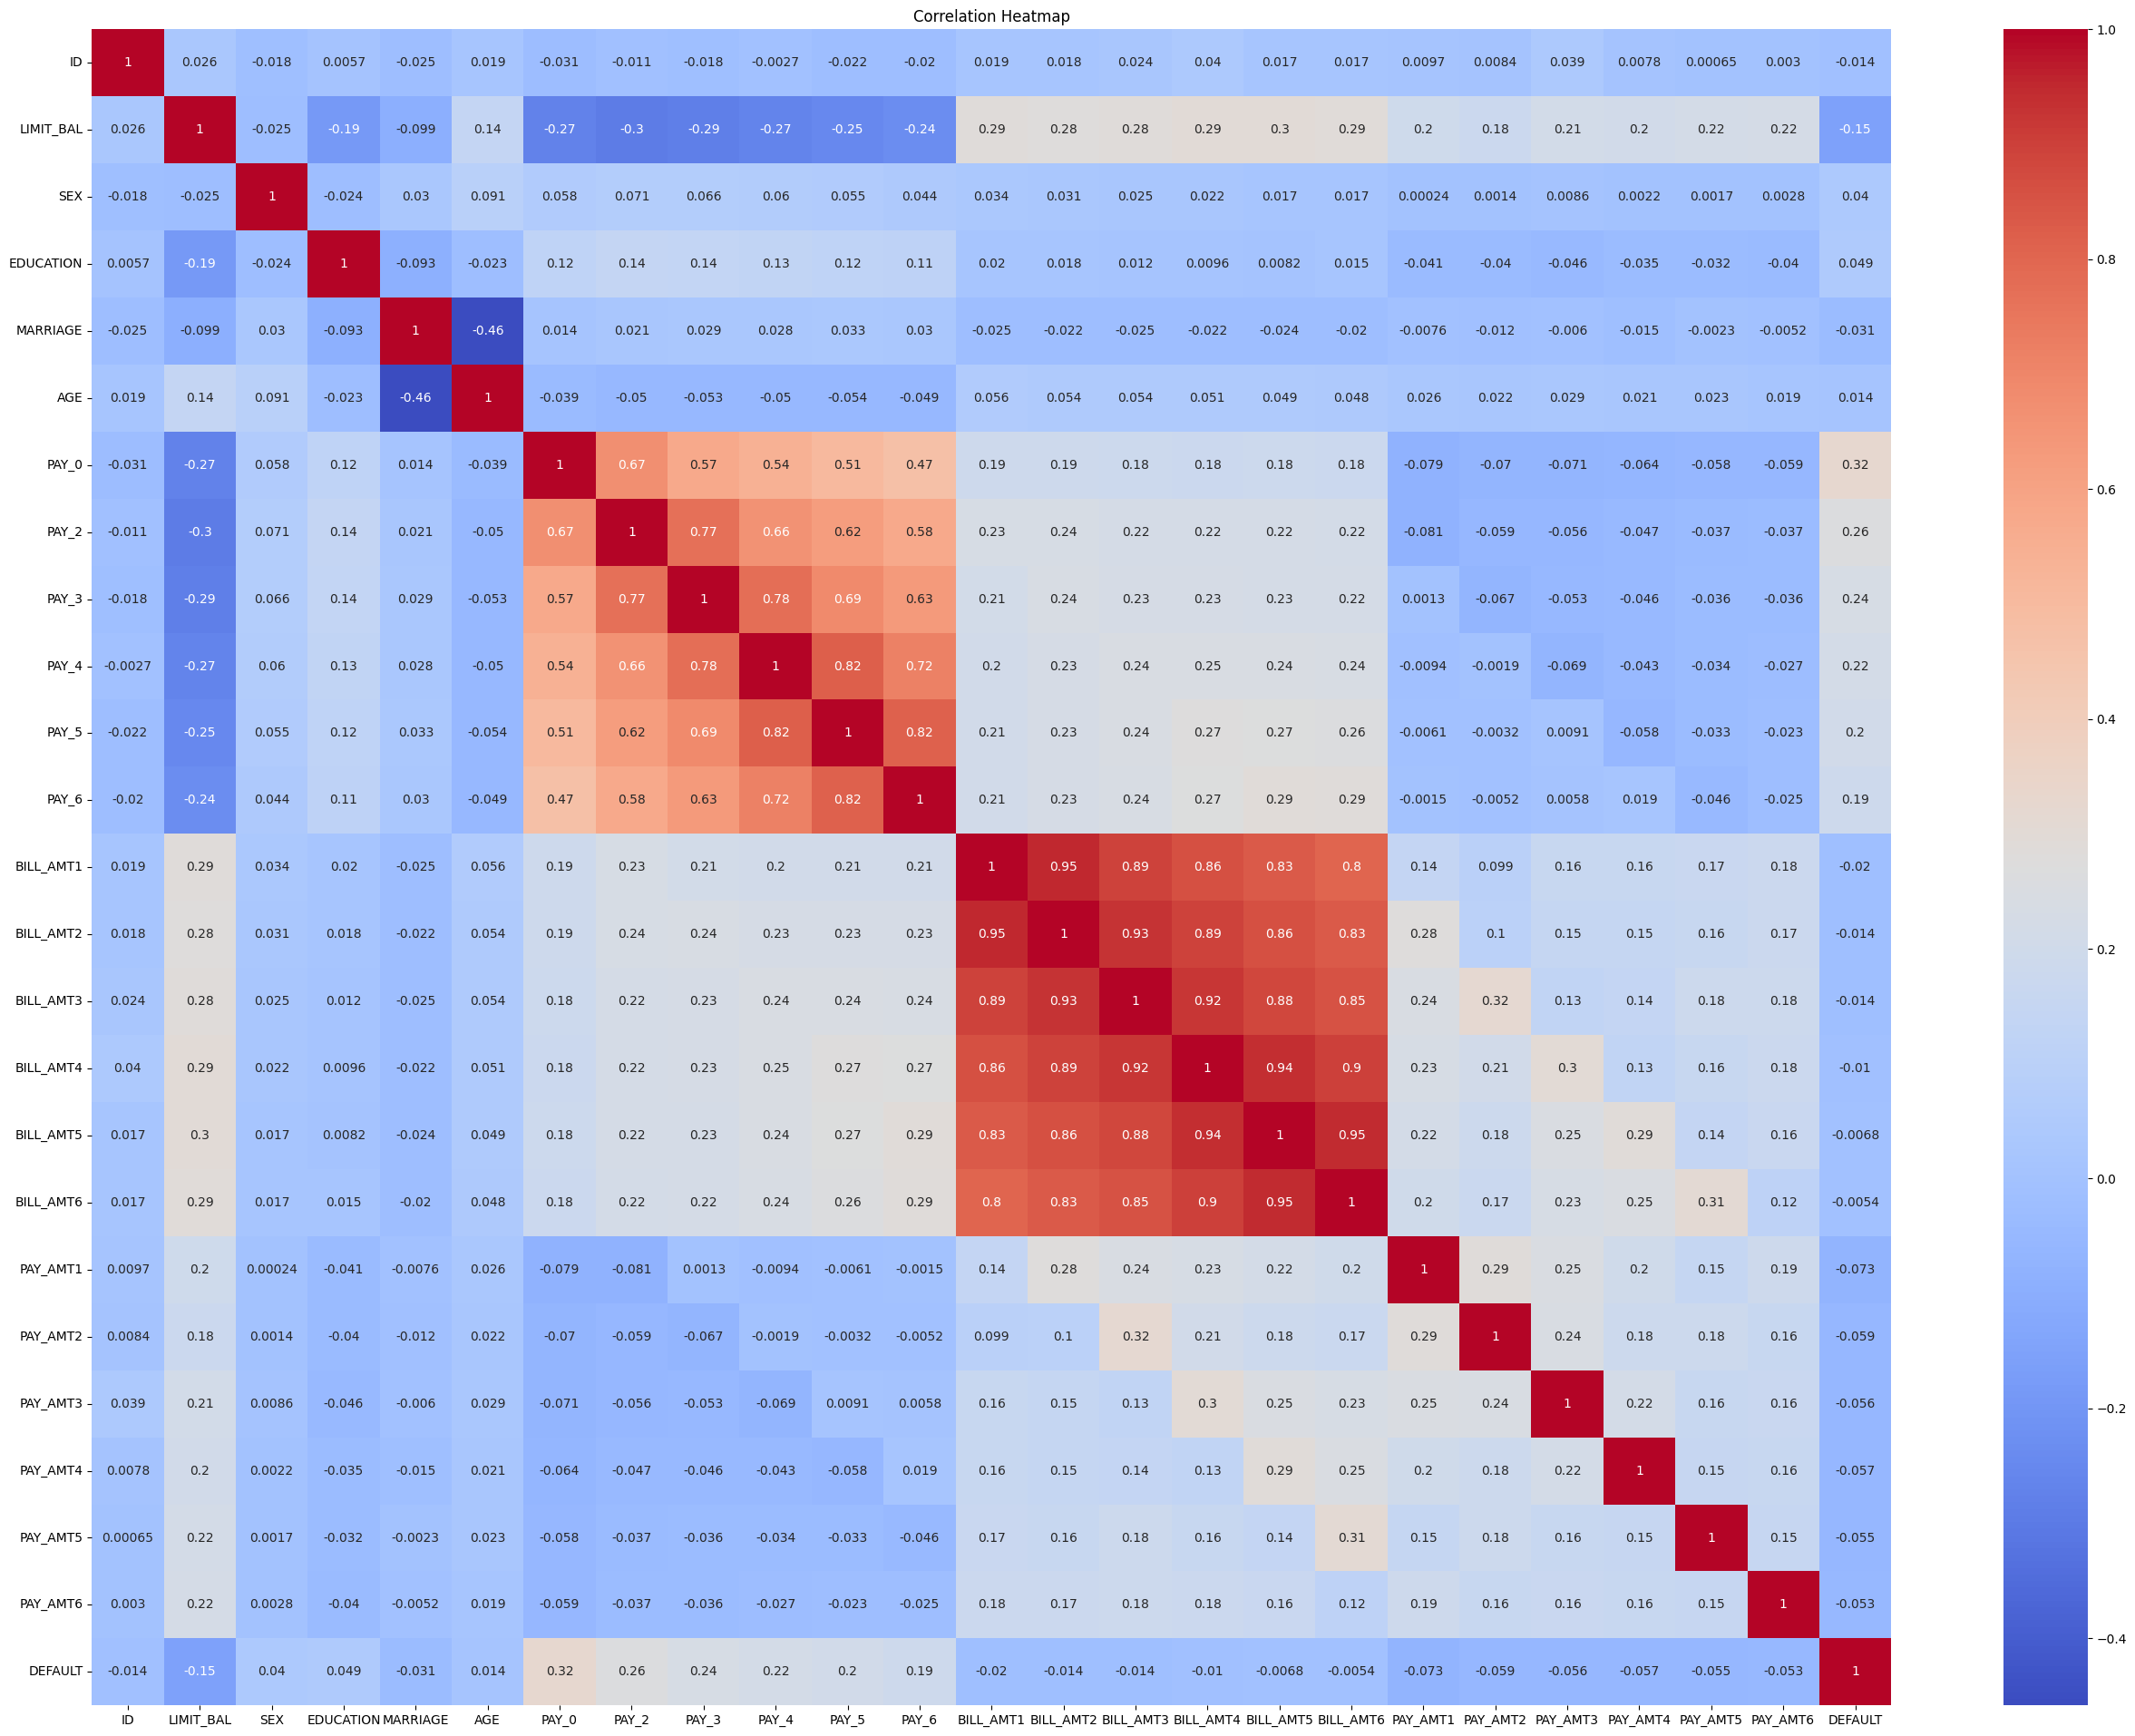

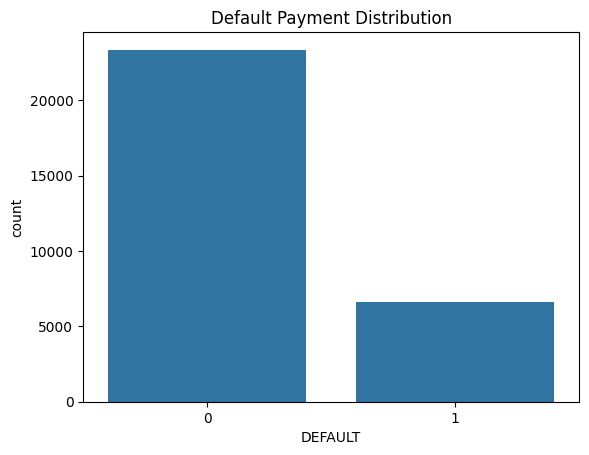

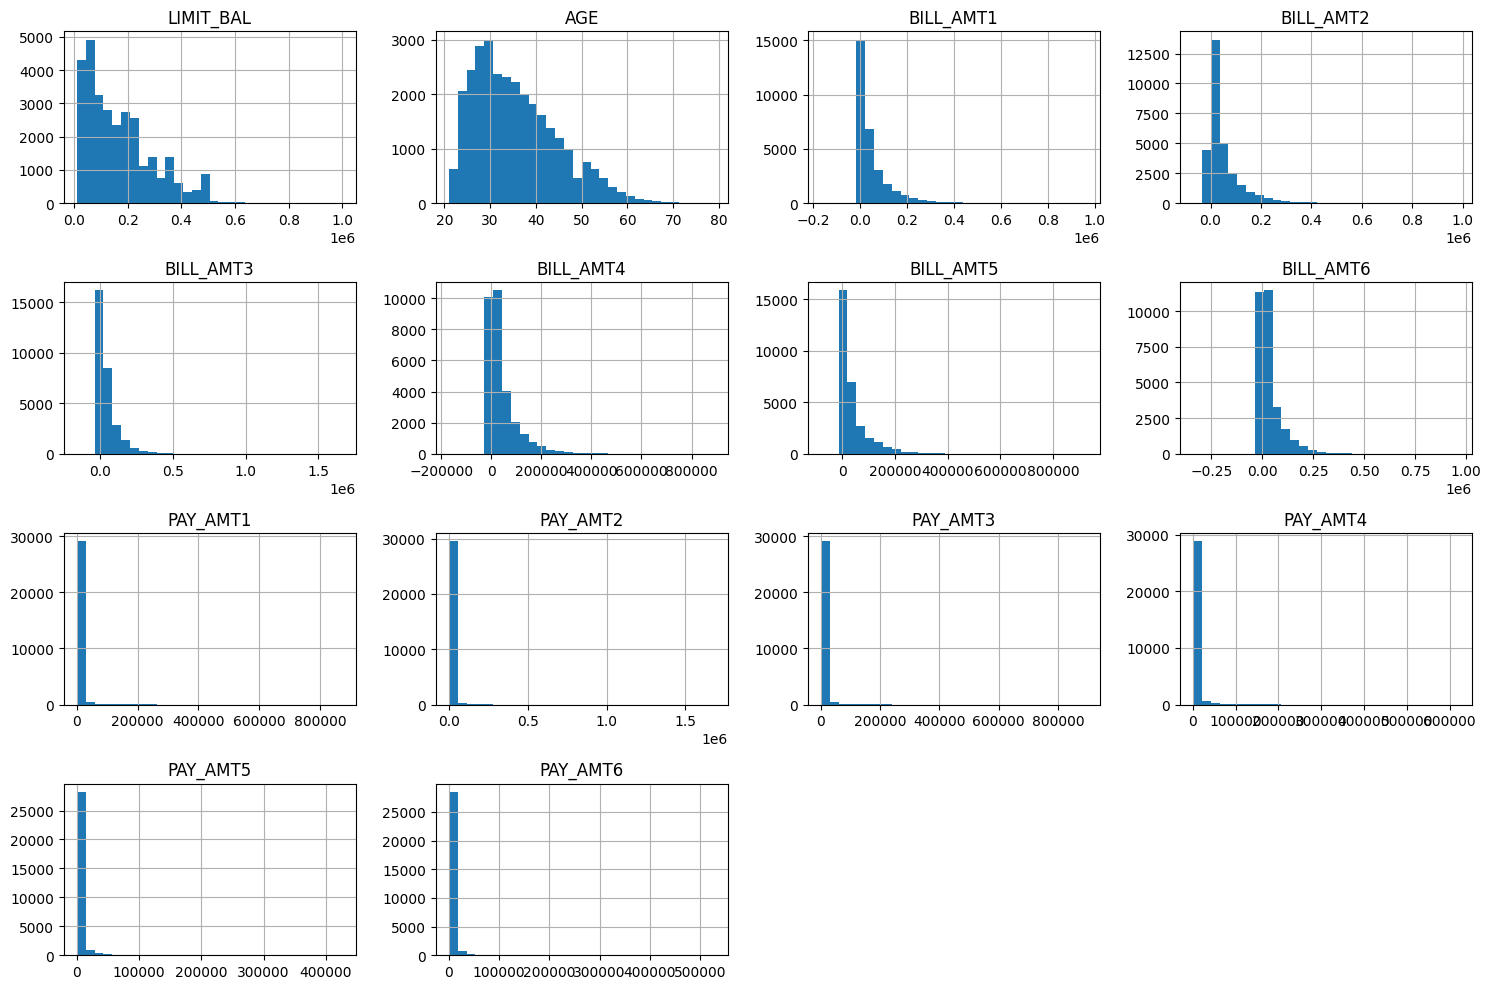

In [83]:
# Correlation heatmap
plt.figure(figsize=(32, 24))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Class distribution
sns.countplot(x='DEFAULT', data=data)
plt.title('Default Payment Distribution')
plt.show()

# Distribution of numeric features
numeric_columns = ['LIMIT_BAL', 'AGE'] + [f'BILL_AMT{i}' for i in range(1, 7)] + [f'PAY_AMT{i}' for i in range(1, 7)]
data[numeric_columns].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()


In [84]:
# Create new features: payment-to-bill ratio, handling division by zero
for i in range(1, 7):
    data[f'PAY_RATIO_{i}'] = data[f'PAY_AMT{i}'] / (data[f'BILL_AMT{i}'].replace(0, np.nan))  # Avoid division by zero

# Drop rows with NaN values introduced by division
data.dropna(subset=[f'PAY_RATIO_{i}' for i in range(1, 7)], inplace=True)

# Feature scaling for numerical columns
scaler = StandardScaler()
scaled_columns = ['LIMIT_BAL', 'AGE'] + [f'BILL_AMT{i}' for i in range(1, 7)] + [f'PAY_AMT{i}' for i in range(1, 7)] + [f'PAY_RATIO_{i}' for i in range(1, 7)]
data[scaled_columns] = scaler.fit_transform(data[scaled_columns])

# Explicitly check for remaining NaN or inf values
nan_count = data.isnull().sum().sum()
inf_count = np.isinf(data).sum().sum()

# Display a summary of cleaned data
print(f"Data cleaning summary:")
print(f"Remaining NaN values: {nan_count}")
print(f"Remaining inf values: {inf_count}")
print(f"Data shape after cleaning: {data.shape}")



Data cleaning summary:
Remaining NaN values: 0
Remaining inf values: 0
Data shape after cleaning: (23887, 31)


In [85]:
# Split data
X = data.drop('DEFAULT', axis=1)
y = data['DEFAULT']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


In [86]:
# Train a classification model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      5569
           1       0.88      0.82      0.85      5569

    accuracy                           0.85     11138
   macro avg       0.86      0.85      0.85     11138
weighted avg       0.86      0.85      0.85     11138

Confusion Matrix:
 [[4968  601]
 [1017 4552]]
ROC AUC Score: 0.9222854654745035


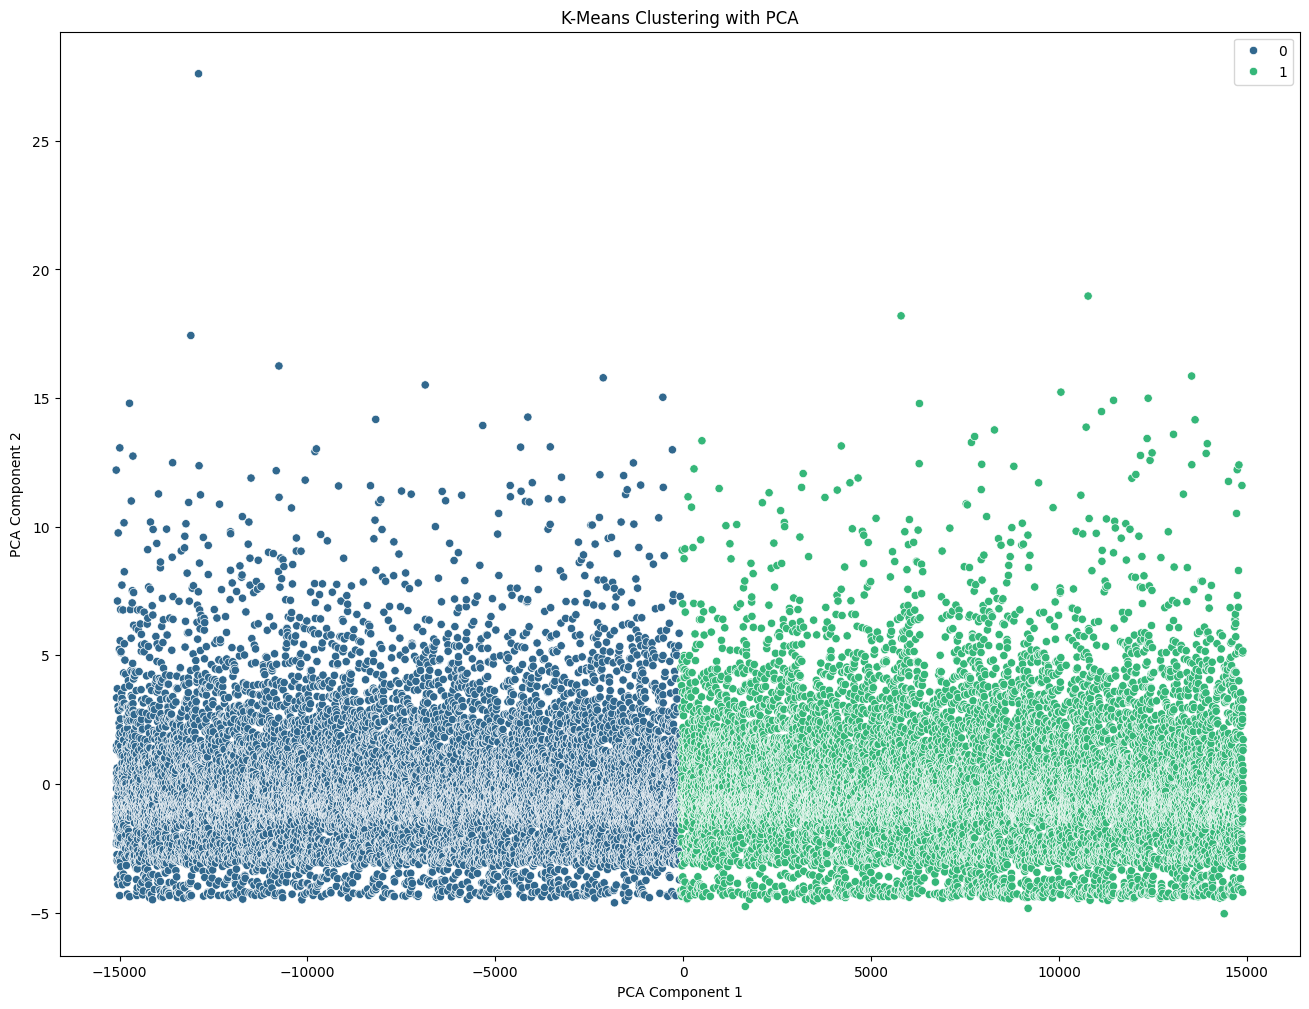

In [87]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize clusters using K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.figure(figsize=(16, 12))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title('K-Means Clustering with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


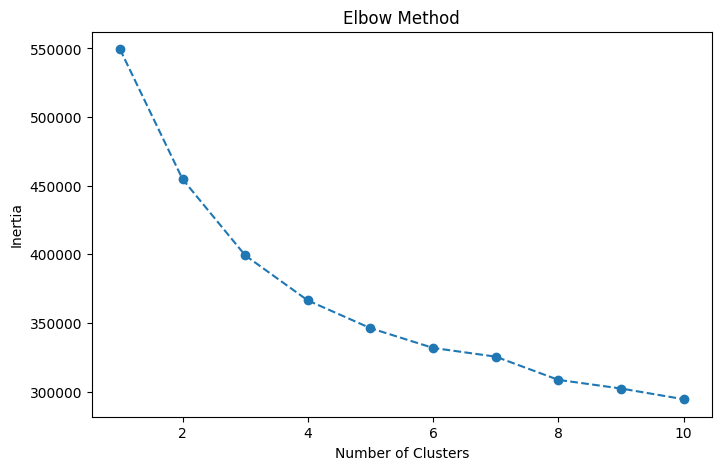

<ipython-input-88-9b8dcda45357>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmentation_data['Cluster'] = kmeans.fit_predict(segmentation_data_scaled)
<ipython-input-88-9b8dcda45357>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmentation_data['Risk_Level'] = segmentation_data['Cluster'].map(risk_mapping)
<ipython-input-88-9b8dcda45357>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Cluster Profiles with Risk Levels:
         LIMIT_BAL       SEX  EDUCATION  MARRIAGE       AGE     PAY_0  \
Cluster                                                                 
0        -0.481905  0.413202   3.835433  1.149937 -0.095095  0.453591   
1         0.899769  0.427900   3.457562  0.986784  0.175627  0.265786   
2         0.616653  0.381859   3.181407  1.001130  0.122744 -0.922369   

            PAY_2     PAY_3     PAY_4     PAY_5  ...  BILL_AMT3  BILL_AMT4  \
Cluster                                          ...                         
0        0.499160  0.477530  0.429441  0.371343  ...  -0.189508  -0.197972   
1        0.239354  0.212335  0.165932  0.141263  ...   1.907322   1.920848   
2       -0.999839 -0.988541 -0.989671 -0.977405  ...  -0.611220  -0.599138   

         BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
Cluster                                                                 
0        -0.200954  -0.198241 -0.162953 -0.131268 -0.159594 -0

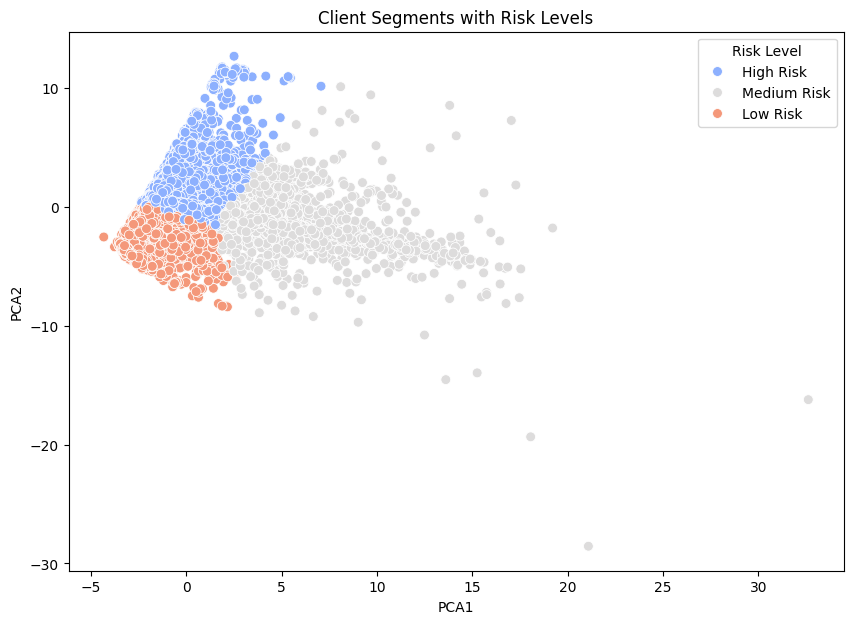

In [88]:
# Select demographic and payment-related variables
selected_columns = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
segmentation_data = data[selected_columns]

# Normalize numerical features
scaler = StandardScaler()
segmentation_data_scaled = scaler.fit_transform(segmentation_data)

# Determine Optimal Number of Clusters (Elbow Method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segmentation_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means Clustering
optimal_clusters = 3  # Choose based on the Elbow Curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
segmentation_data['Cluster'] = kmeans.fit_predict(segmentation_data_scaled)

# Cluster Profiling with mean
cluster_profile = segmentation_data.groupby('Cluster').mean()

# Sort clusters by risk (assuming higher PAY_0 means higher risk)
cluster_risks = cluster_profile['PAY_0'].sort_values(ascending=False).index
risk_mapping = {cluster_risks[0]: 'High Risk', cluster_risks[1]: 'Medium Risk', cluster_risks[2]: 'Low Risk'}

# Map clusters to risk levels
segmentation_data['Risk_Level'] = segmentation_data['Cluster'].map(risk_mapping)

# Display cluster profiles with risk levels
print("Cluster Profiles with Risk Levels:")
print(cluster_profile)
print("\nRisk Mapping:")
for cluster, risk in risk_mapping.items():
    print(f"Cluster {cluster} = {risk}")

# Visualize clusters using PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(segmentation_data_scaled)
segmentation_data['PCA1'] = pca_result[:, 0]
segmentation_data['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(data=segmentation_data, x='PCA1', y='PCA2', hue='Risk_Level', palette='coolwarm', s=50)
plt.title('Client Segments with Risk Levels')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Risk Level')
plt.show()


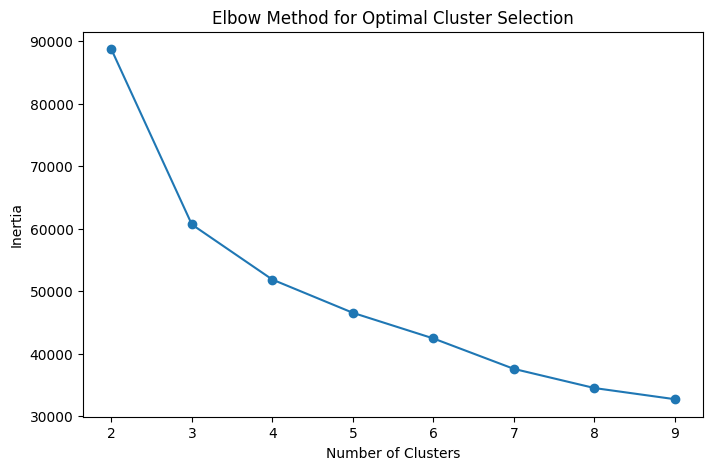

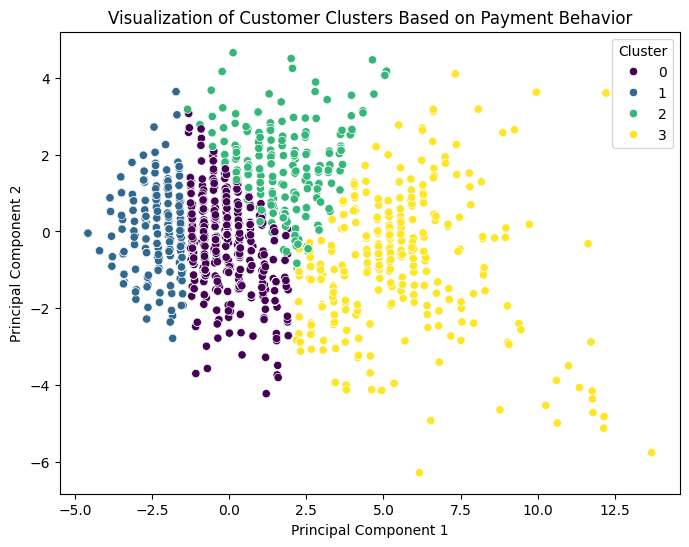

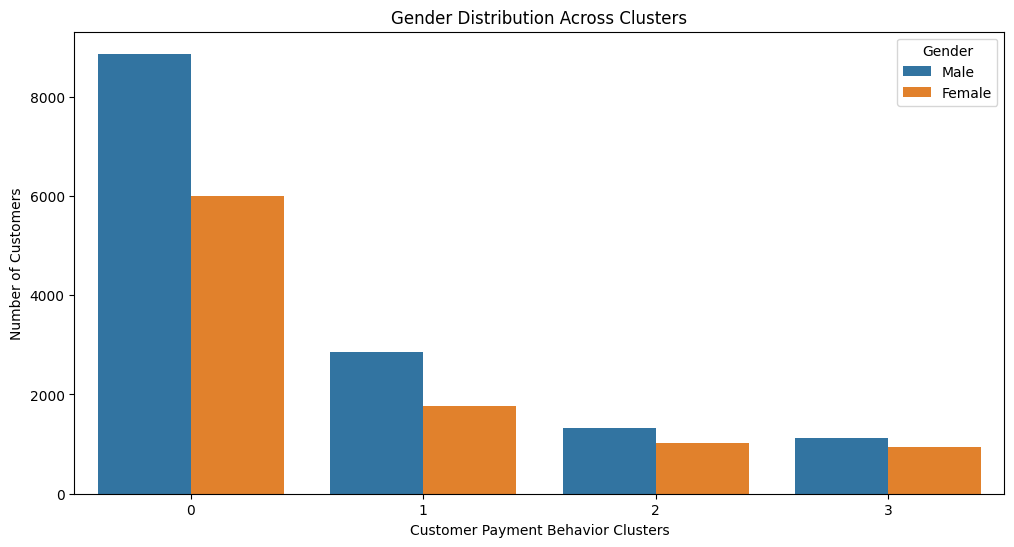

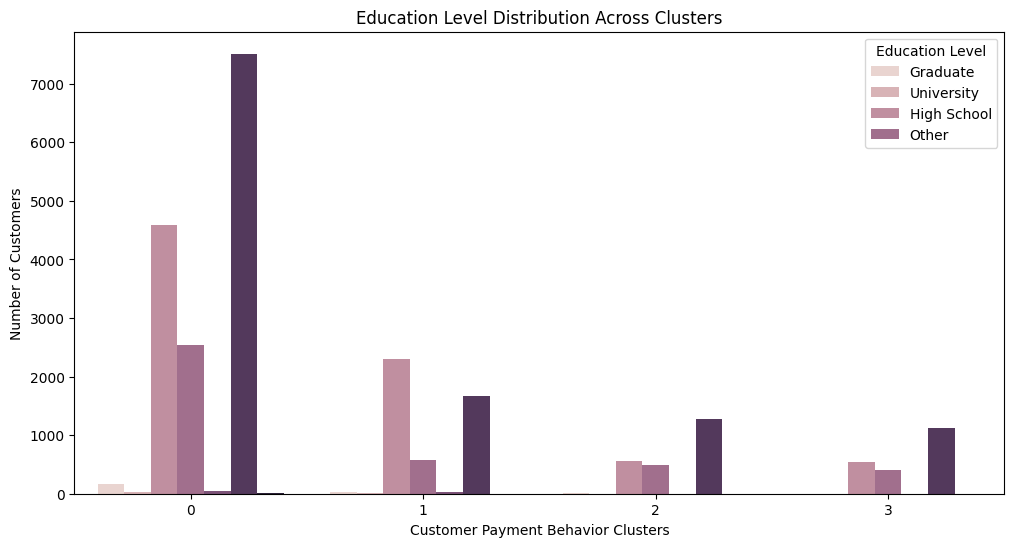

In [89]:
###Different approach (graphs indicated in the report)
# Extract payment behavior columns
pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
payment_data = data[pay_features]

# Standardize payment behavior
scaler = StandardScaler()
payment_data_scaled = scaler.fit_transform(payment_data)

# Determine optimal number of clusters using the Elbow Method
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(payment_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Selection')
plt.show()

# Apply KMeans with optimal clusters (Assume optimal K from elbow plot)
optimal_k = 4  # Adjust based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
data['Cluster'] = kmeans.fit_predict(payment_data_scaled)

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(payment_data_scaled)
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=data['Cluster'], palette='viridis', data=data)
plt.title('Visualization of Customer Clusters Based on Payment Behavior')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Cluster Distribution by Gender
plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='SEX', data=data)
plt.title('Gender Distribution Across Clusters')
plt.xlabel('Customer Payment Behavior Clusters')
plt.ylabel('Number of Customers')
plt.legend(title="Gender", labels=["Male", "Female"])
plt.show()

# Cluster Distribution by Education Level
plt.figure(figsize=(12, 6))
sns.countplot(x='Cluster', hue='EDUCATION', data=data)
plt.title('Education Level Distribution Across Clusters')
plt.xlabel('Customer Payment Behavior Clusters')
plt.ylabel('Number of Customers')
plt.legend(title="Education Level", labels=["Graduate", "University", "High School", "Other"])
plt.show()

<ipython-input-90-fe412e1b99e1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['PAY_STD'] = analysis_data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].std(axis=1)
<ipython-input-90-fe412e1b99e1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_data['PAY_TREND'] = analysis_data.apply(calculate_trend, axis=1)
<ipython-input-90-fe412e1b99e1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

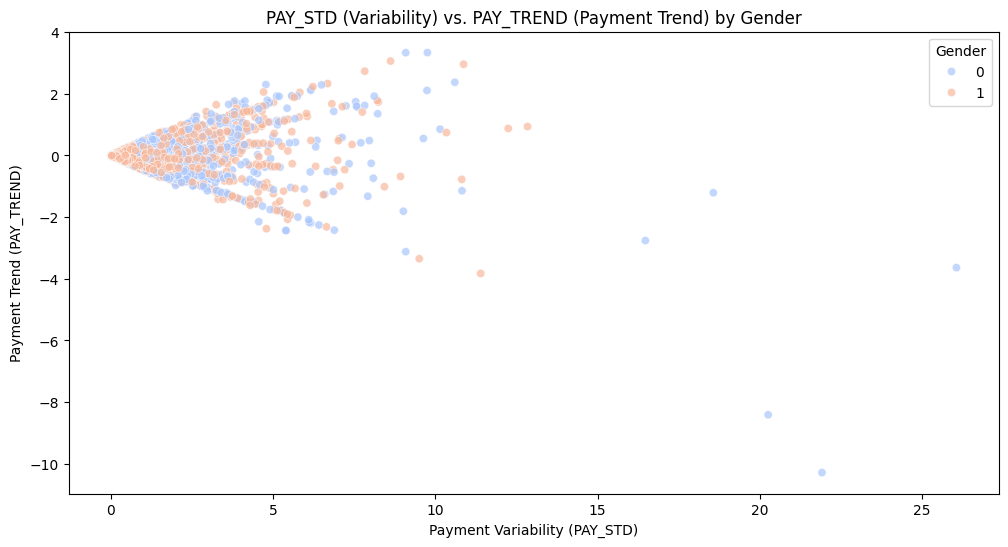

In [90]:
# Load dataset (ensure 'data' is your cleaned dataset)
selected_columns = [
    'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]
analysis_data = data[selected_columns]


# Payment Variability (Standard Deviation of Payments)
analysis_data['PAY_STD'] = analysis_data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].std(axis=1)



analysis_data['PAY_TREND'] = analysis_data.apply(calculate_trend, axis=1)

# Late Payment Frequency (Count of Months with Delays)
analysis_data['LATE_PAYMENTS'] = analysis_data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(lambda x: (x > 0).sum(), axis=1)


# Payment Trend vs. Standard Deviation by Demographics
plt.figure(figsize=(12, 6))
sns.scatterplot(data=analysis_data, x='PAY_STD', y='PAY_TREND', hue='SEX', palette='coolwarm', alpha=0.7)
plt.title("PAY_STD (Variability) vs. PAY_TREND (Payment Trend) by Gender")
plt.xlabel("Payment Variability (PAY_STD)")
plt.ylabel("Payment Trend (PAY_TREND)")
plt.legend(title="Gender")
plt.show()

Contains NaN after cleaning: False
Contains Inf after cleaning: False


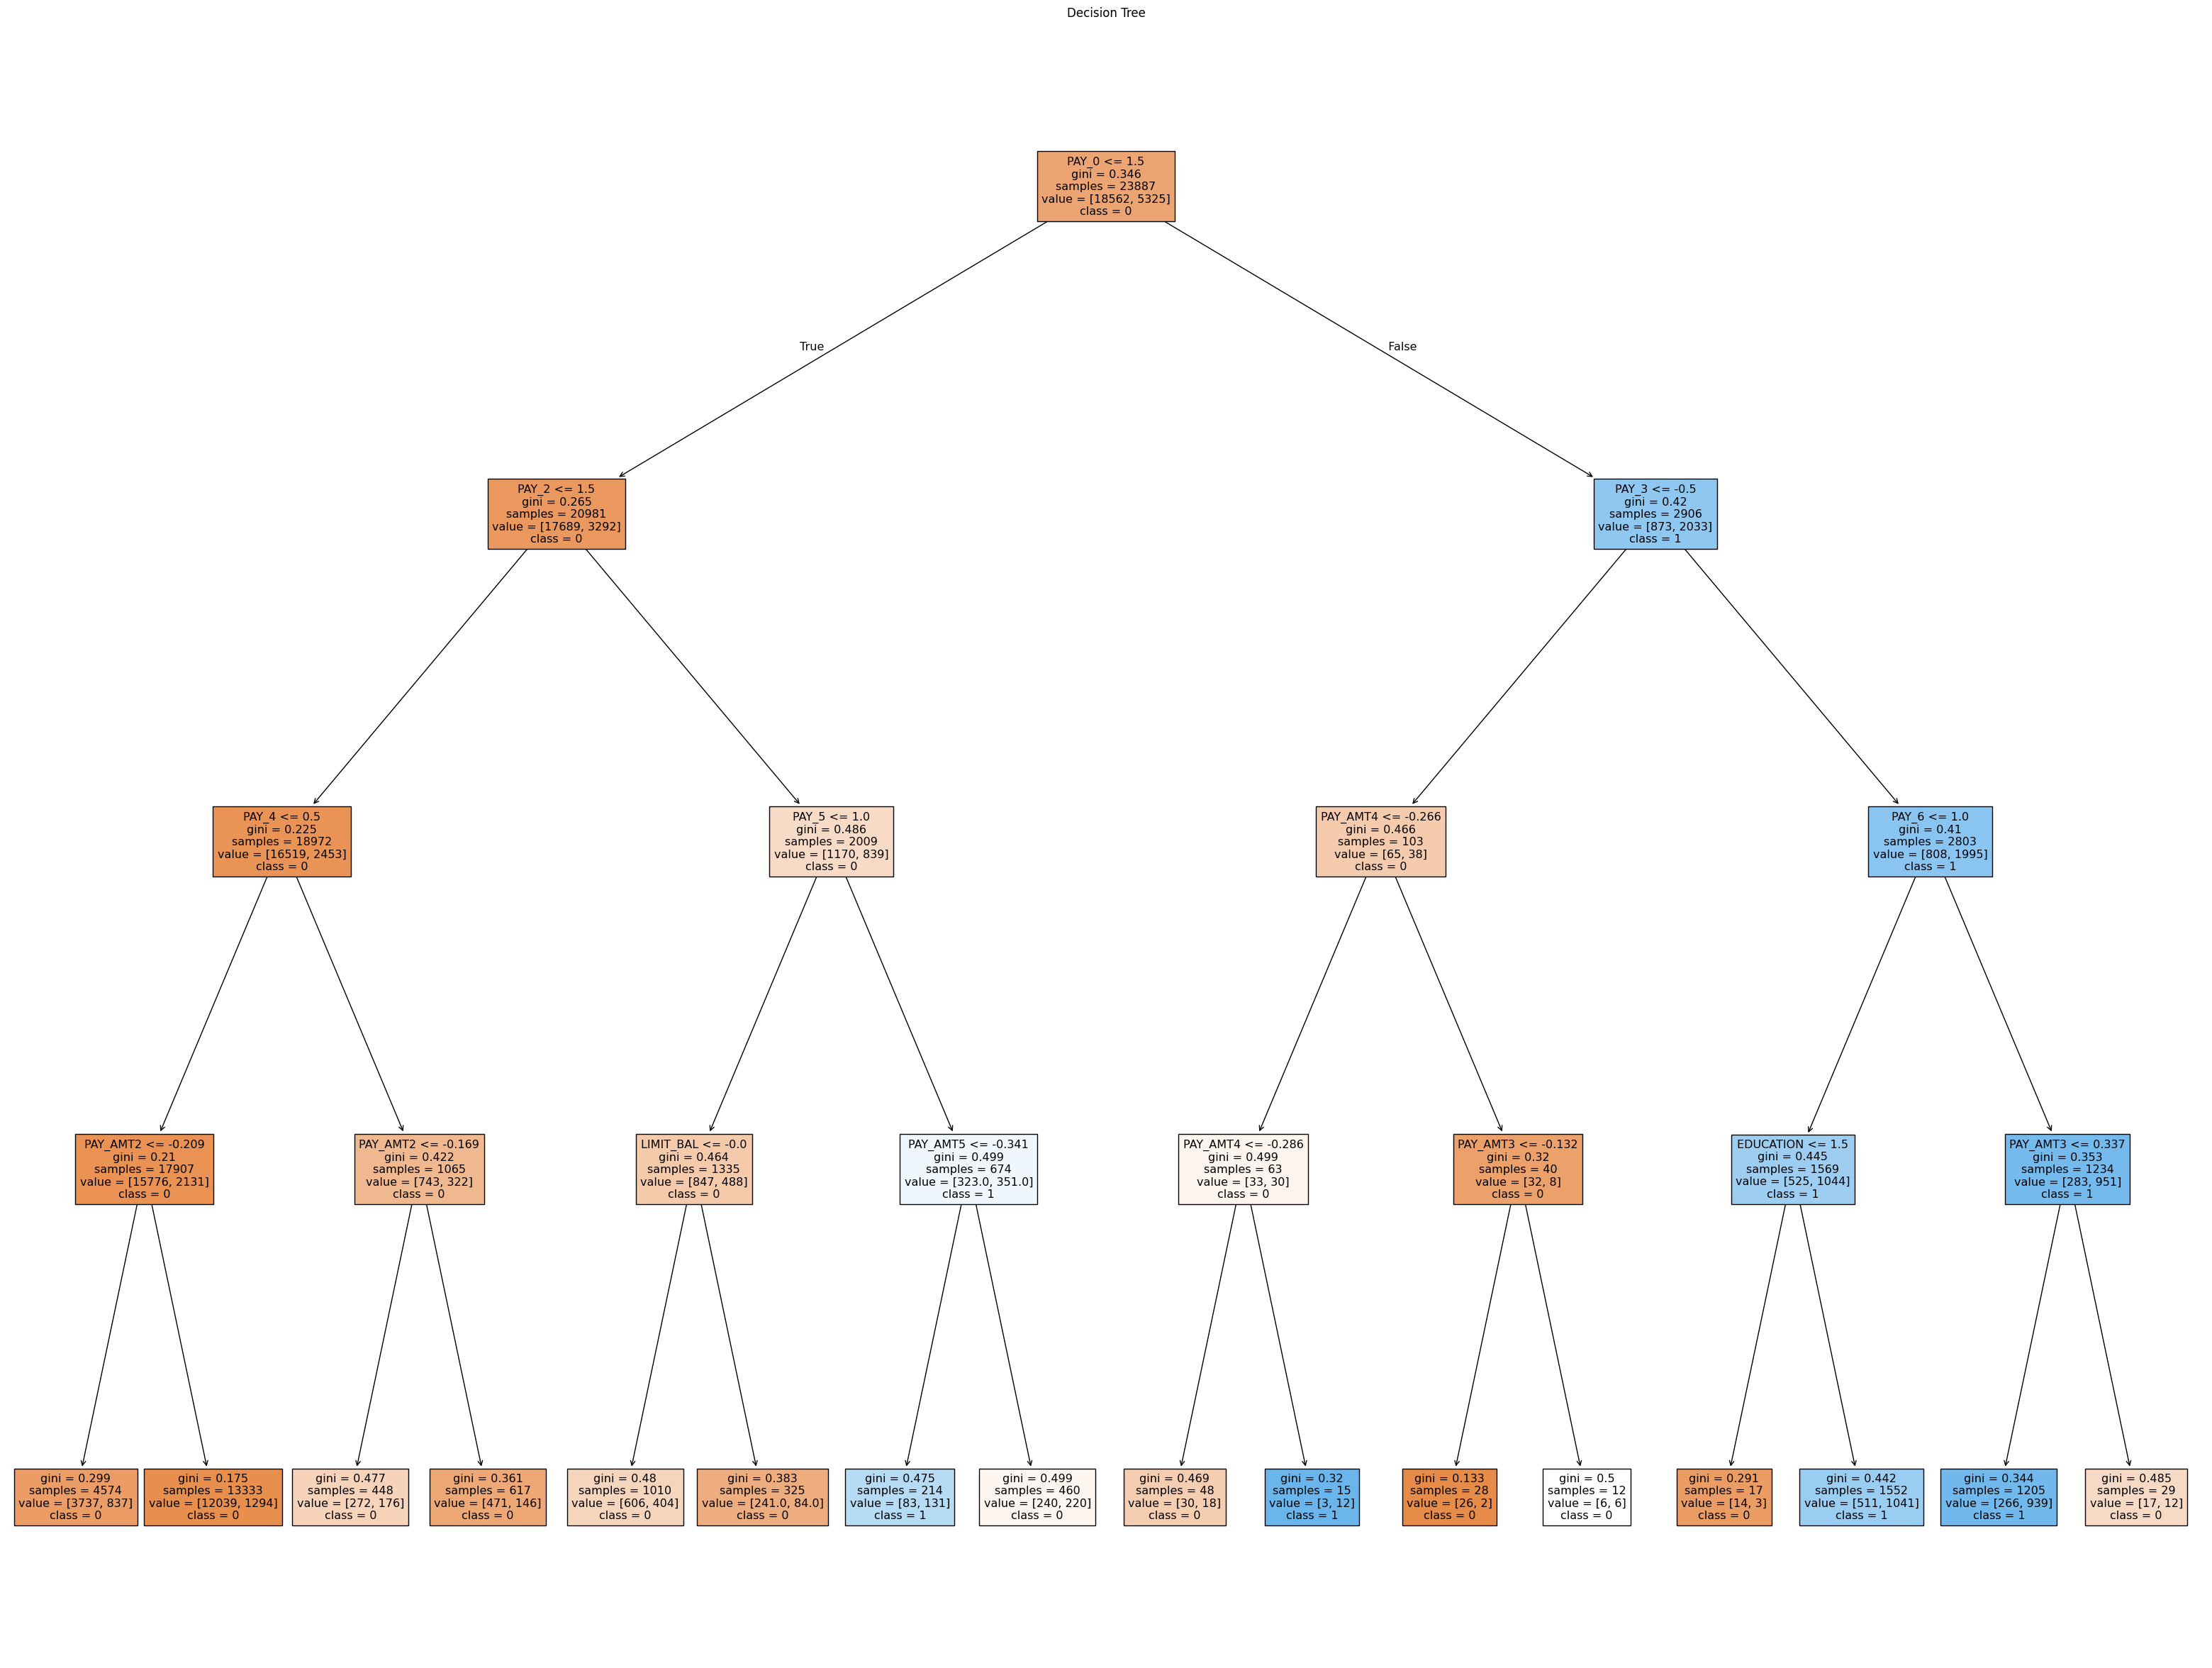

In [94]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Replace inf and NaN values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Verify cleaning
print("Contains NaN after cleaning:", np.any(np.isnan(X)))
print("Contains Inf after cleaning:", np.any(np.isinf(X)))

# Train the Decision Tree Model
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X, y.astype(str)) # Convert y to string before fitting

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 30))
plot_tree(tree_model, feature_names=X.columns, class_names=tree_model.classes_, filled=True)
plt.title("Decision Tree")
plt.show()


<ipython-input-101-cb473dbc99b4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmentation_data['PAY_RATIO_MEAN'] = segmentation_data[['PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_RATIO_6']].mean(axis=1)
<ipython-input-101-cb473dbc99b4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segmentation_data['DEBT_TO_LIMIT'] = segmentation_data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1) / segmentation_data['LIMIT_BAL']
<ipyt

Random Forest Classification Report:
              precision    recall  f1-score   support

   High Risk       0.94      0.95      0.95      1113
    Low Risk       0.99      0.99      0.99      5051
 Medium Risk       0.98      0.97      0.98      1003

    accuracy                           0.98      7167
   macro avg       0.97      0.97      0.97      7167
weighted avg       0.98      0.98      0.98      7167

Random Forest Accuracy: 0.98

XGBoost Classification Report:
              precision    recall  f1-score   support

   High Risk       0.94      0.96      0.95      1113
    Low Risk       0.99      0.98      0.99      5051
 Medium Risk       0.98      0.98      0.98      1003

    accuracy                           0.98      7167
   macro avg       0.97      0.97      0.97      7167
weighted avg       0.98      0.98      0.98      7167

XGBoost Accuracy: 0.98


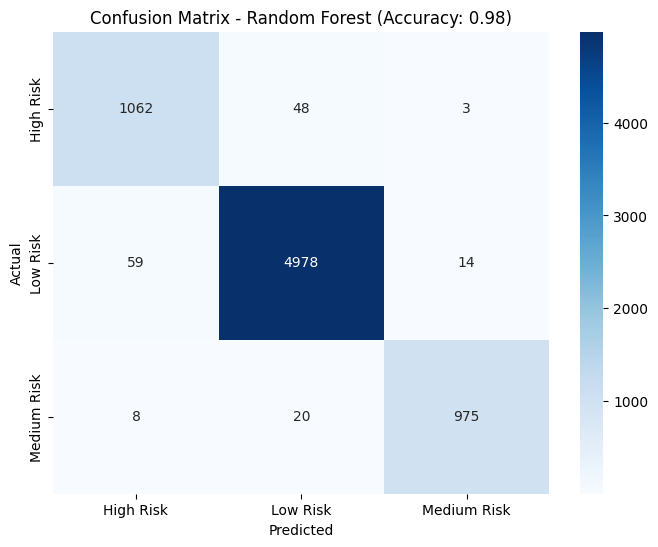

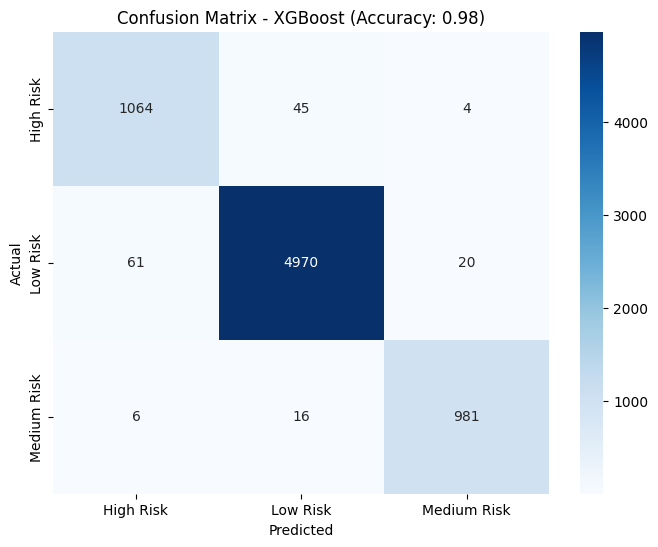

<ipython-input-101-cb473dbc99b4>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances_rf, x='Importance', y='Feature', palette='viridis')


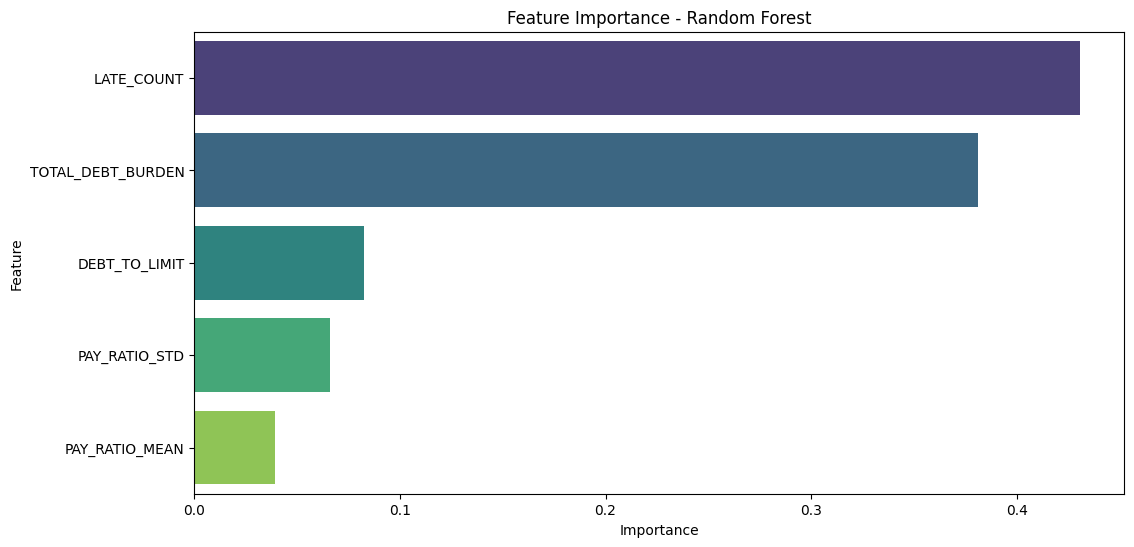

<ipython-input-101-cb473dbc99b4>:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances_xgb, x='Importance', y='Feature', palette='magma')


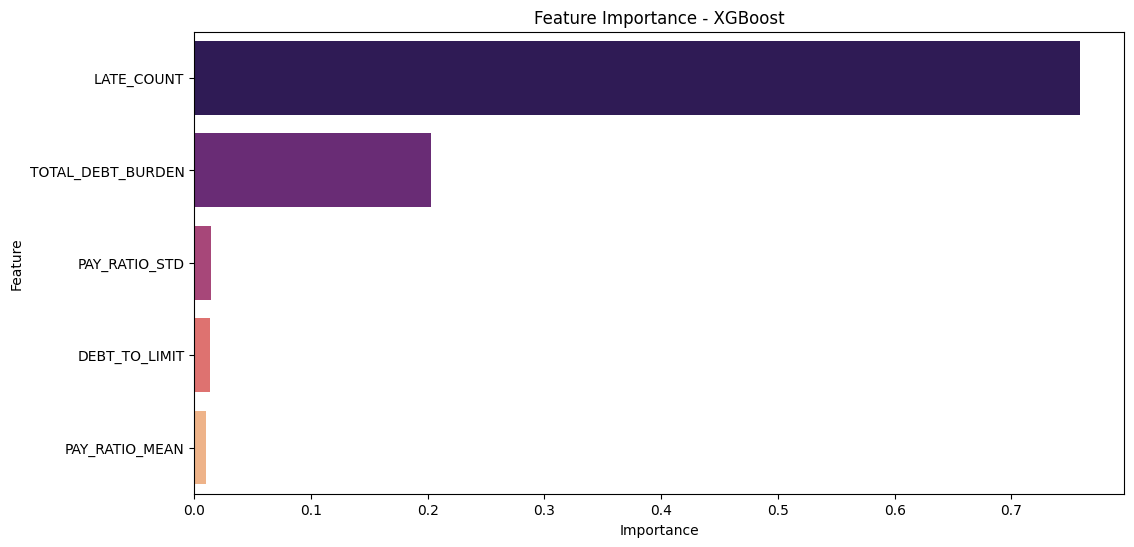

In [101]:
# Feature Engineering
selected_columns = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_RATIO_6', # Add these columns
    # 'Risk_Level' # Remove 'Risk_Level' from selected_columns
]
segmentation_data = data[selected_columns]



# Calculate new features and add them to segmentation_data
segmentation_data['PAY_RATIO_MEAN'] = segmentation_data[['PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_RATIO_6']].mean(axis=1)
segmentation_data['DEBT_TO_LIMIT'] = segmentation_data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1) / segmentation_data['LIMIT_BAL']
segmentation_data['PAY_RATIO_STD'] = segmentation_data[['PAY_RATIO_1', 'PAY_RATIO_2', 'PAY_RATIO_3', 'PAY_RATIO_4', 'PAY_RATIO_5', 'PAY_RATIO_6']].std(axis=1)
segmentation_data['LATE_COUNT'] = segmentation_data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(lambda x: (x > 0).sum(), axis=1)
segmentation_data['TOTAL_DEBT_BURDEN'] = segmentation_data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)


optimal_clusters = 3  # Choose based on the Elbow Curve
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
segmentation_data['Cluster'] = kmeans.fit_predict(scaler.fit_transform(segmentation_data)) # scaling before kmeans

# Cluster Profiling with mean
cluster_profile = segmentation_data.groupby('Cluster').mean()

# Sort clusters by risk (assuming higher PAY_0 means higher risk)
cluster_risks = cluster_profile['PAY_0'].sort_values(ascending=False).index
risk_mapping = {cluster_risks[0]: 'High Risk', cluster_risks[1]: 'Medium Risk', cluster_risks[2]: 'Low Risk'}

# Map clusters to risk levels
segmentation_data['Risk_Level'] = segmentation_data['Cluster'].map(risk_mapping) # Add this line to include 'Risk_Level'


# Select features and target
X = segmentation_data[['PAY_RATIO_MEAN', 'DEBT_TO_LIMIT', 'PAY_RATIO_STD', 'LATE_COUNT', 'TOTAL_DEBT_BURDEN']]
y = segmentation_data['Risk_Level']


# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Scale the features for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# XGBoost Model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix - Random Forest (Accuracy: {accuracy_rf:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion Matrix for XGBoost
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Confusion Matrix - XGBoost (Accuracy: {accuracy_xgb:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance - Random Forest
feature_importances_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances_rf, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Feature Importance - XGBoost
feature_importances_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importances_xgb, x='Importance', y='Feature', palette='magma')
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()